<h1>Predicting Sales Units for a Seasonal Retailer<h1>
<h2>Oscar Windrath-Carr<h2>

In [30]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2
  Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from tabulate import tabulate
import calendar

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Data Understanding, Exploratory Data Analysis and Feature Engineering:

In [33]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/MasterDataTEST_OP.csv')

<ipython-input-33-a8abe69b5f1c>:2: DtypeWarning: Columns (17,20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/drive/MyDrive/MasterDataTEST_OP.csv')


In [34]:
# Check data types
print(data.info())

# Missing values check
missing_values = data.isnull().sum()
print("Missing Values:\n", missing_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152765 entries, 0 to 152764
Data columns (total 37 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   sku_id                         152765 non-null  object 
 1   cal_date                       152765 non-null  object 
 2   gsales_u                       152765 non-null  int64  
 3   gsales_v                       152765 non-null  float64
 4   dc_reg_inventory_u             152765 non-null  int64  
 5   oo_inventory_u                 152765 non-null  int64  
 6   next_delivery_quantity_1       152765 non-null  int64  
 7   weeks_to_next_delivery_1       152765 non-null  int64  
 8   next_delivery_date_1           23003 non-null   object 
 9   next_delivery_quantity_2       152765 non-null  int64  
 10  weeks_to_next_delivery_2       152765 non-null  int64  
 11  next_delivery_date_2           3281 non-null    object 
 12  next_delivery_quantity_3      

In [35]:
#Converting data types where needed

# Converting the date to datetime format
data['cal_date'] = pd.to_datetime(data['cal_date'])

# Define the conversion dictionary
convert_dict = {'promo_days_this_week': int, 'mkdn_days_this_week': int}

# Convert columns using the dictionary
data = data.astype(convert_dict)

# Removing columns not being used
data = data.drop([
'next_delivery_date_1'
,'next_delivery_quantity_2'
,'weeks_to_next_delivery_2'
,'next_delivery_date_2'
,'next_delivery_quantity_3'
,'weeks_to_next_delivery_3'
,'next_delivery_date_3'
,'next_delivery_quantity_4'
,'weeks_to_next_delivery_4'
,'next_delivery_date_4'
,'next_delivery_quantity_5'
,'weeks_to_next_delivery_5'
,'next_delivery_date_5'
,'outstanding_delivery_quantity'
,'size_code'
], axis=1)

In [36]:
# Create encoder objects
label_encoder1 = preprocessing.LabelEncoder()
label_encoder2 = preprocessing.LabelEncoder()
onehotencoder = preprocessing.OneHotEncoder()

# Label encoding for selected columns
data['sku_id'] = label_encoder1.fit_transform(data['sku_id'])
data['category_desc'] = label_encoder2.fit_transform(data['category_desc'])

# One-hot encoding for selected columns
data = pd.get_dummies(data, columns=['division_desc', 'department_desc'],  dtype='int', drop_first=True)

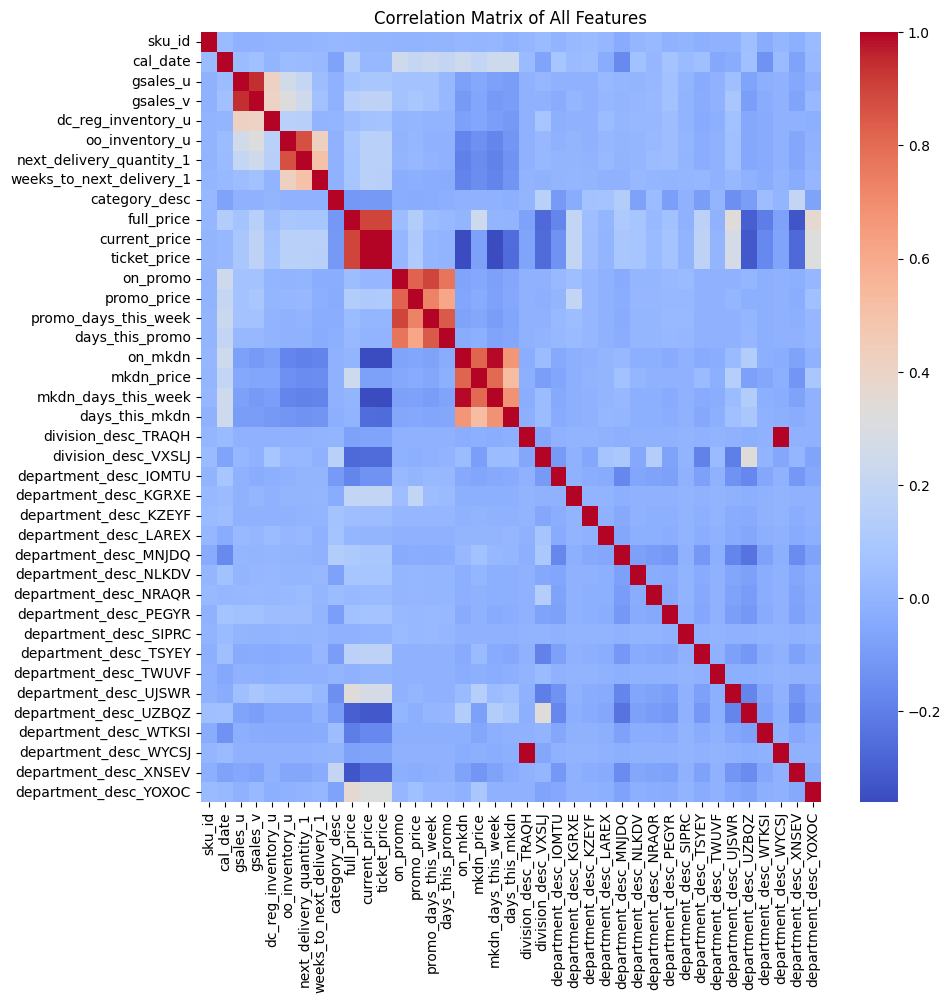

In [37]:
# Seaborn heatmap to check for correlation
plt.figure(figsize=(10,10))
sns.heatmap(data[data['cal_date'] <= '2023-12-31'].corr(), cmap='coolwarm')
plt.title('Correlation Matrix of All Features')
plt.show()

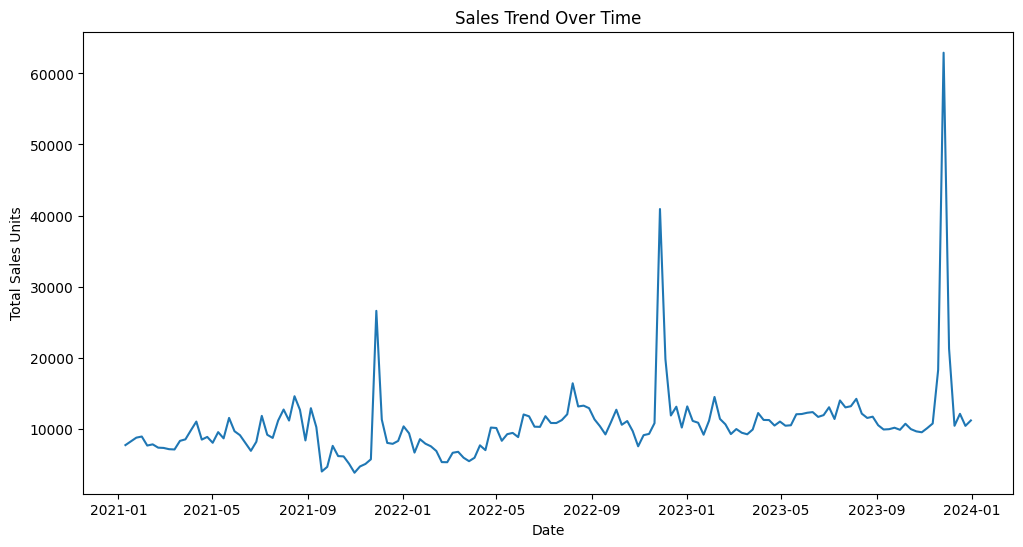

In [38]:
# Sales trend over time
sales_trend = data[data['cal_date'] <= '2023-12-31'].groupby('cal_date')['gsales_u'].sum()
plt.figure(figsize=(12, 6))
plt.plot(sales_trend)
plt.title('Sales Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales Units')
plt.show()

In [39]:
# Sales when on promotion or markdown vs. sales when not on promotion or markdown

# Total sales units when on markdown (on_mkdn = 1)
sales_on_mkdn = data[(data['on_mkdn'] == 1) & (data['cal_date'] <= '2023-12-31')]['gsales_u'].sum()
# Total sales units when not on markdown (on_mkdn = 0)
sales_not_on_mkdn = data[(data['on_mkdn'] == 0) & (data['cal_date'] <= '2023-12-31')]['gsales_u'].sum()
# Total sales units when on promotion (on_promo = 1)
sales_on_promo = data[(data['on_promo'] == 1) & (data['cal_date'] <= '2023-12-31')]['gsales_u'].sum()
# Total sales units when not on promotion (on_promo = 0)
sales_not_on_promo = data[(data['on_promo'] == 0) & (data['cal_date'] <= '2023-12-31')]['gsales_u'].sum()

# Organizing data into a table format
table_data = [
    ["On Markdown", sales_on_mkdn],
    ["Not on Markdown", sales_not_on_mkdn],
    ["On Promotion", sales_on_promo],
    ["Not on Promotion", sales_not_on_promo]
]

print(tabulate(table_data, headers=["Condition", "Total Sales Units"], tablefmt="pretty"))


+------------------+-------------------+
|    Condition     | Total Sales Units |
+------------------+-------------------+
|   On Markdown    |      306070       |
| Not on Markdown  |      1349650      |
|   On Promotion   |      103214       |
| Not on Promotion |      1552506      |
+------------------+-------------------+


In [40]:
# Calculate discounts
data['mkdn_discount'] = ((data['full_price'] - data['mkdn_price']) / data['full_price']) * 100
data['promo_discount'] = ((data['full_price'] - data['promo_price']) / data['full_price']) * 100

# Only consider discounts when on markdown or promotion
data['mkdn_discount'] = data['mkdn_discount'].where(data['on_mkdn'] == 1, 0)
data['promo_discount'] = data['promo_discount'].where(data['on_promo'] == 1, 0)

# Eliminating errors
data.loc[data['mkdn_discount'] < 0, 'mkdn_discount'] = 0
data.loc[data['promo_discount'] < 0, 'promo_discount'] = 0

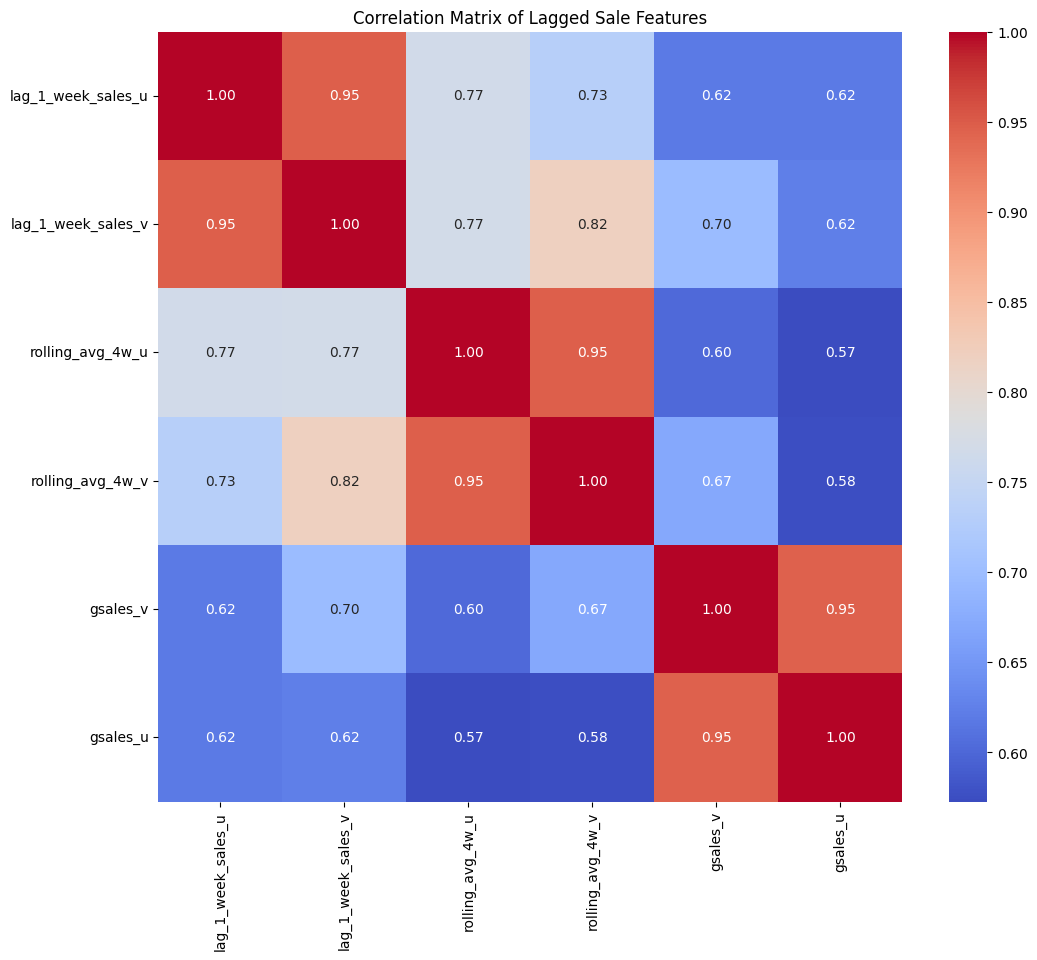

In [41]:
# Lagged sales features

# Sales units and value for the previous week
data['lag_1_week_sales_u'] = data.groupby('sku_id')['gsales_u'].shift(1)
data['lag_1_week_sales_u'] = data['lag_1_week_sales_u'].fillna(0) #filling missing values with 0

data['lag_1_week_sales_v'] = data.groupby('sku_id')['gsales_v'].shift(1)
data['lag_1_week_sales_v'] = data['lag_1_week_sales_v'].fillna(0) #filling missing values with 0

# Rolling average sales units and value for the past 4 weeks
data['rolling_avg_4w_u'] = data.groupby('sku_id')['gsales_u'].shift(1).rolling(window=4, min_periods=1).mean().reset_index(0, drop=True)
data['rolling_avg_4w_u'] = data['rolling_avg_4w_u'].fillna(0) #filling missing values with 0

data['rolling_avg_4w_v'] = data.groupby('sku_id')['gsales_v'].shift(1).rolling(window=4, min_periods=1).mean().reset_index(0, drop=True)
data['rolling_avg_4w_v'] = data['rolling_avg_4w_v'].fillna(0) #filling missing values with 0

# Correlation Matrix with Sales
lag_features = [
    'lag_1_week_sales_u', 'lag_1_week_sales_v', 'rolling_avg_4w_u',
    'rolling_avg_4w_v'
]
correlation_matrix1 = data[data['cal_date'] <= '2023-12-31'][lag_features + ['gsales_v', 'gsales_u']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix1, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Matrix of Lagged Sale Features')
plt.show()

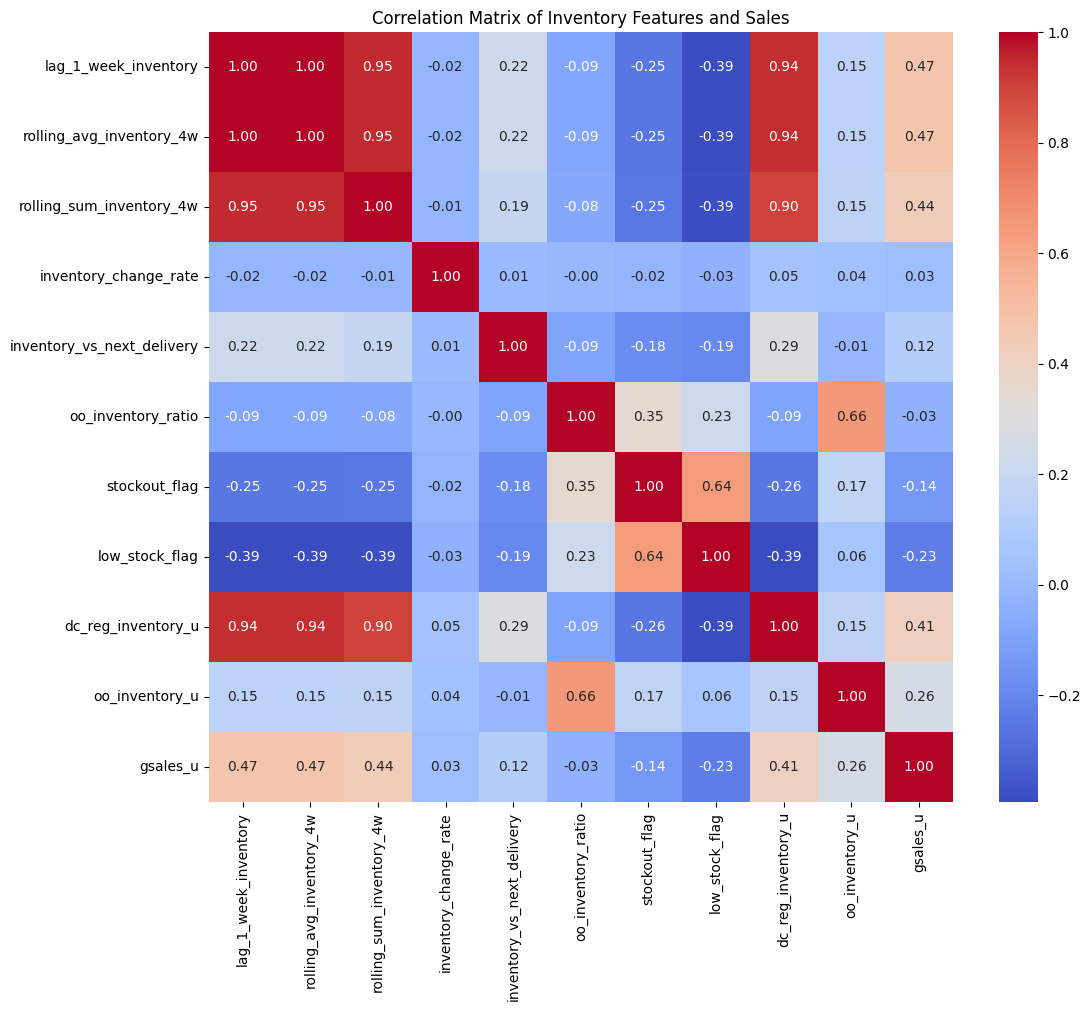

In [42]:
# Inventory feature engineering

# Lagged Inventory Features (1-week lag)
data['lag_1_week_inventory'] = data.groupby('sku_id')['dc_reg_inventory_u'].shift(1)
data['lag_1_week_inventory'] = data['lag_1_week_inventory'].fillna(0) #filling missing values with 0

# Rolling Averages and Totals for Inventory (4 weeks)
data['rolling_avg_inventory_4w'] = data.groupby('sku_id')['dc_reg_inventory_u'].shift(1).rolling(window=4, min_periods=1).mean()
data['rolling_sum_inventory_4w'] = data.groupby('sku_id')['dc_reg_inventory_u'].shift(1).rolling(window=4, min_periods=1).sum()
data['rolling_avg_inventory_4w'] = data['lag_1_week_inventory'].fillna(0) #filling missing values with 0

# Week-over-Week Inventory Change Rate
data['inventory_change_rate'] = data.groupby('sku_id')['dc_reg_inventory_u'].pct_change()

# Inventory Relative to Next Delivery
data['inventory_vs_next_delivery'] = data['dc_reg_inventory_u'] / data['next_delivery_quantity_1'].replace(0, np.nan)

# Weeks Until Next Delivery
data['weeks_to_next_delivery'] = data['weeks_to_next_delivery_1']

# Orders as Proportion of Inventory
data['oo_inventory_ratio'] = data['oo_inventory_u'] / (data['dc_reg_inventory_u'] + 1e-9)

# Binary Flags for Stockouts
data['stockout_flag'] = (data['dc_reg_inventory_u'] <= 0).astype(int)
data['low_stock_flag'] = (data['dc_reg_inventory_u'] < 10).astype(int)

# Correlation Matrix with Sales (gsales_u)
inventory_features = [
    'lag_1_week_inventory', 'rolling_avg_inventory_4w', 'rolling_sum_inventory_4w',
    'inventory_change_rate', 'inventory_vs_next_delivery', 'oo_inventory_ratio',
    'stockout_flag', 'low_stock_flag'
]
correlation_matrix = data[data['cal_date'] <= '2023-12-31'][inventory_features + ['dc_reg_inventory_u', 'oo_inventory_u', 'gsales_u']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Matrix of Inventory Features and Sales')
plt.show()

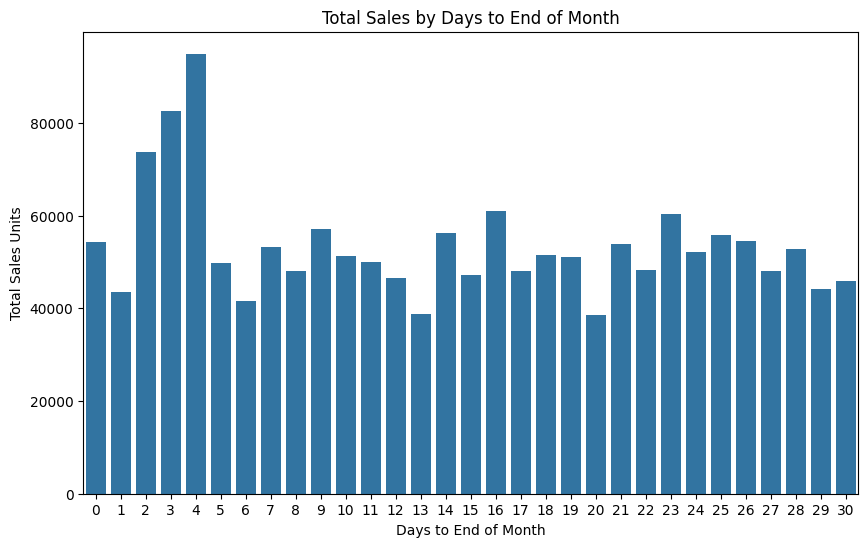

In [43]:
# Time-based features

# Month and week
data['month'] = data['cal_date'].dt.month
data['week'] = data['cal_date'].dt.isocalendar().week

# Days to the end of the month
def days_to_end_of_month(date):
    if pd.isnull(date):  # Handle missing or invalid dates
        return None
    last_day = calendar.monthrange(date.year, date.month)[1]
    return last_day - date.day

# Apply the function to calculate days to end of the month
data['days_to_end_of_month'] = data['cal_date'].apply(days_to_end_of_month)

sales_by_days_to_end = data[data['cal_date'] <= '2023-12-31'].groupby('days_to_end_of_month')['gsales_u'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='days_to_end_of_month', y='gsales_u', data=sales_by_days_to_end)
plt.title('Total Sales by Days to End of Month')
plt.xlabel('Days to End of Month')
plt.ylabel('Total Sales Units')
plt.show()

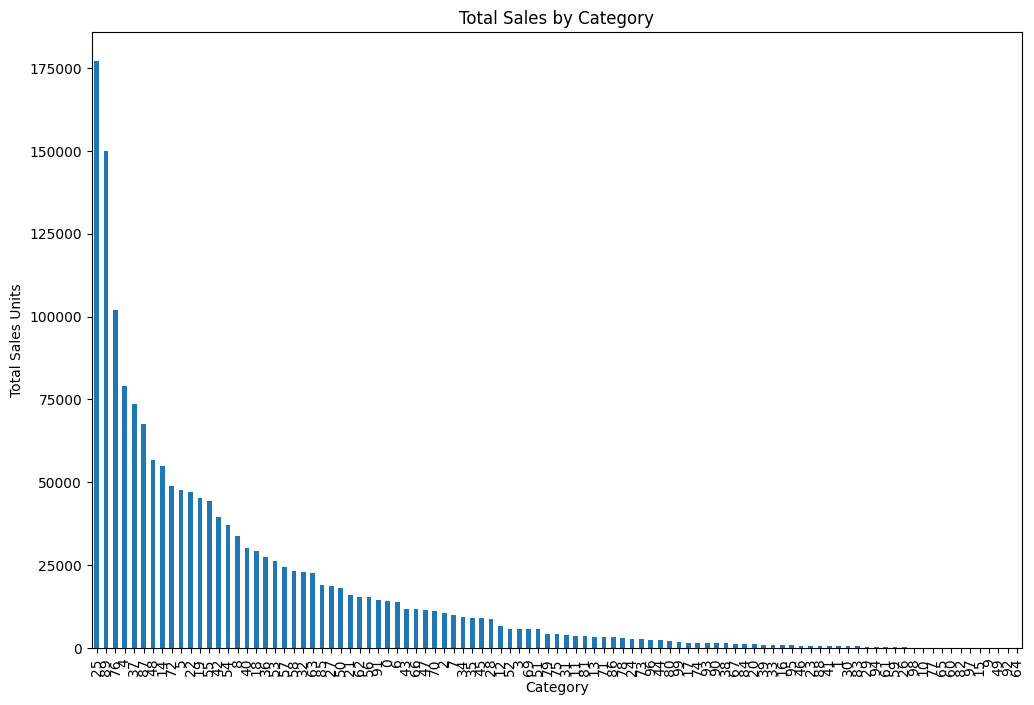

In [44]:
# Sales by category

sales_category = data[data['cal_date'] <= '2023-12-31'].groupby('category_desc')['gsales_u'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sales_category.plot(kind='bar')
plt.title('Total Sales by Category')
plt.ylabel('Total Sales Units')
plt.xlabel('Category')
plt.xticks(rotation=90)
plt.show()

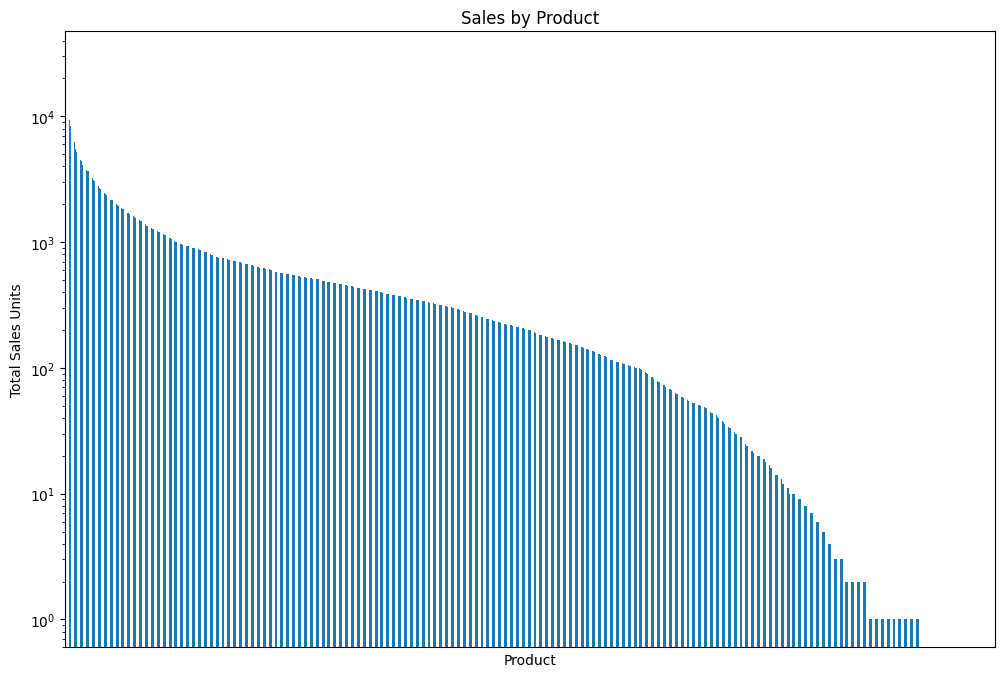

In [45]:
# Sales by product

sales_product = data[data['cal_date'] <= '2023-12-31'].groupby('sku_id')['gsales_u'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sales_product.plot(kind='bar')
plt.title('Sales by Product')
plt.ylabel('Total Sales Units')
plt.xlabel('Product')
plt.xticks(rotation=90)
plt.yscale('log')
plt.xticks([]) # Too many products to have labels
plt.show()

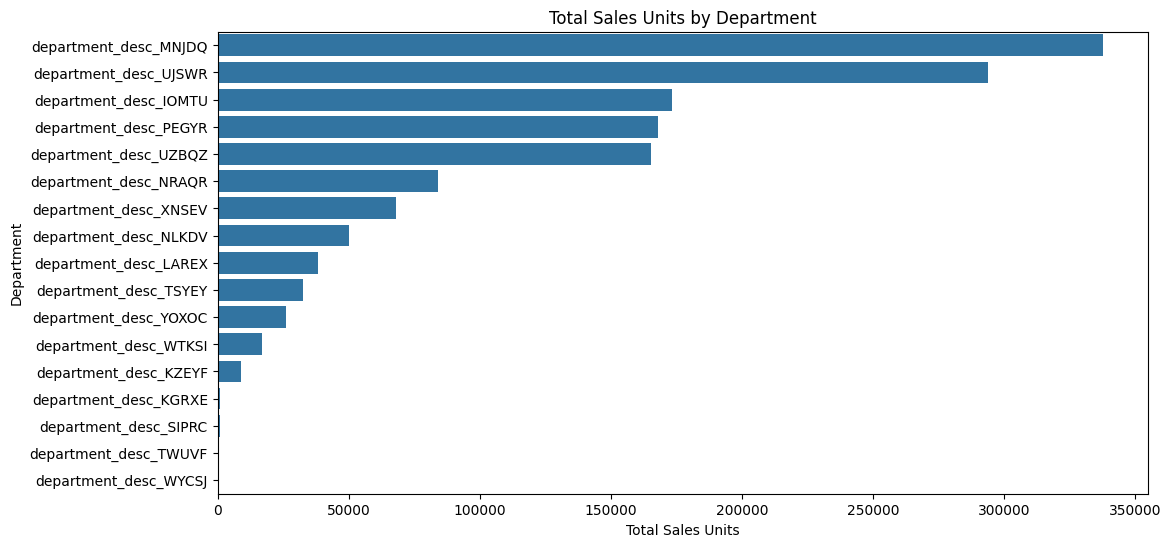

In [46]:
#Sales by department

# Select department columns
department_columns = [col for col in data.columns if col.startswith('department_desc_')]

# Multiply the one-hot encoded department columns by sales units to sum the sales
department_sales = data[data['cal_date'] <= '2023-12-31'][department_columns].multiply(data['gsales_u'], axis=0)

# Sum the sales by department
department_sales_sum = department_sales.sum().reset_index()
department_sales_sum.columns = ['Department', 'Total Sales Units']

# Sort the results in descending order of sales
department_sales_sum = department_sales_sum.sort_values(by='Total Sales Units', ascending=False)

# Plot the total sales by department
plt.figure(figsize=(12, 6))
sns.barplot(x='Total Sales Units', y='Department', data=department_sales_sum)
plt.title('Total Sales Units by Department')
plt.xlabel('Total Sales Units')
plt.ylabel('Department')
plt.show()


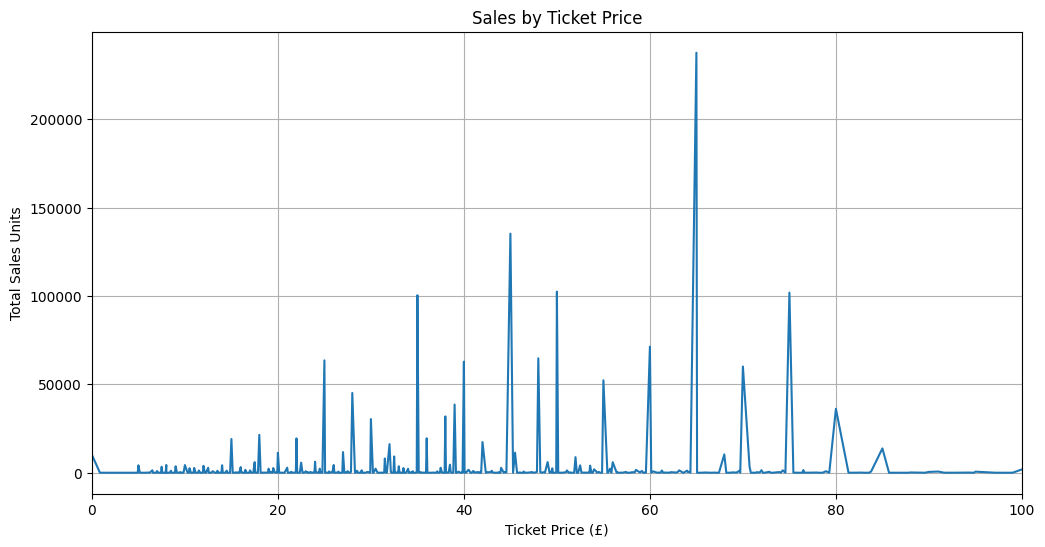

In [47]:
# Sales by ticket price

# Group by ticket price and sum sales units
ticket_sales_summary = data[data['cal_date'] <= '2023-12-31'].groupby('ticket_price')['gsales_u'].sum().reset_index()

# Plot summed sales units against ticket price
plt.figure(figsize=(12, 6))
sns.lineplot(x='ticket_price', y='gsales_u', data=ticket_sales_summary)
plt.title('Sales by Ticket Price')
plt.xlabel('Ticket Price (£)')
plt.ylabel('Total Sales Units')
plt.xlim(0,100)
plt.grid(True)
plt.show()


#Model Building, Selection and Tuning<h2>

In [48]:
# Selecting features, training and test data

# Define features
features = ['sku_id', 'category_desc', 'ticket_price', 'mkdn_discount', 'on_promo', 'on_mkdn', 'promo_discount', 'month', 'days_to_end_of_month'
, 'lag_1_week_inventory', 'lag_1_week_sales_u', 'lag_1_week_sales_v'] + department_columns

# Features data, normalised and not normalised and target data
X = data[features]
scaler = preprocessing.StandardScaler()
X_norm = scaler.fit_transform(X)
y = data['gsales_u']

# Train-test split
X_train = X[data['cal_date'] <= '2023-12-31']
X_train_norm = X_norm[data['cal_date'] <= '2023-12-31']
y_train = y[data['cal_date'] <= '2023-12-31']

X_test = X[data['cal_date'] > '2023-12-31']
X_test_norm = X_norm[data['cal_date'] > '2023-12-31']
y_test = y[data['cal_date'] > '2023-12-31']

In [49]:
# Baseline linear model

model = linear_model.Ridge(alpha=1)
model.fit(X_train_norm, y_train)

# Predictions
y_pred = model.predict(X_test_norm)

R2 Score: 0.6971
Mean Squared Error: 157.2166
Mean Absolute Error: 5.5198


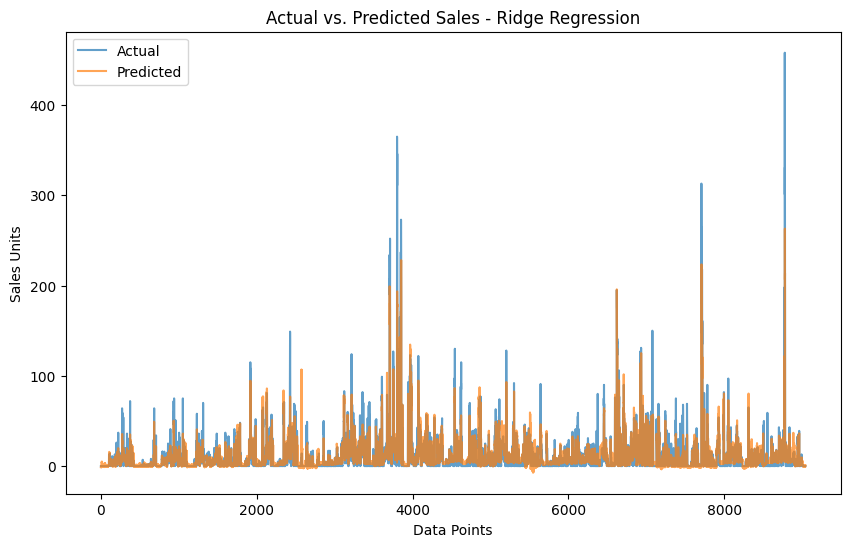

In [50]:
# Baseline linear model results

# Metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

# Visualizing Actual vs. Predicted Sales
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', alpha=0.7)
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.legend()
plt.xlabel('Data Points')
plt.ylabel('Sales Units')
plt.title('Actual vs. Predicted Sales - Ridge Regression')
plt.show()

In [51]:
# XGBoost Regressor with tuning

# Initialize model
xgb_model = xgb.XGBRegressor(random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [150, 200, 300],      # Number of trees
    'max_depth': [5, 7, 9],               # Depth of trees
    'learning_rate': [0.001, 0.01, 0.1],  # Step size
    'subsample': [0.1, 0.3, 0.5],         # Fraction of samples for each tree
}


# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='r2',         # Use R-squared as the evaluation metric
    cv=3,                 # 3-fold cross-validation
    verbose=1,            # Verbosity level
    n_jobs=-1             # Use all available CPU cores
)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.1}


R2 Score: 0.7597
Mean Squared Error: 124.7154
Mean Absolute Error: 4.5420


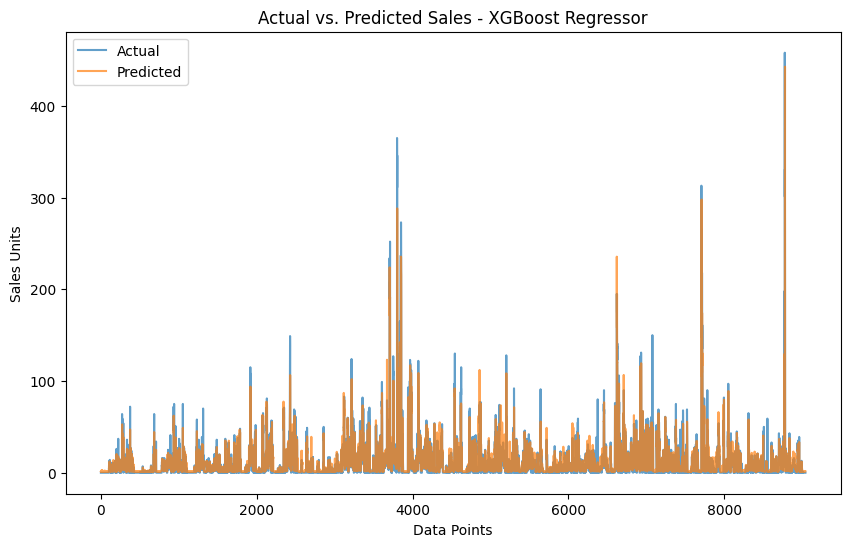

In [52]:
# Use the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Predict on the test set
y_predxgb = best_model.predict(X_test)

# Metrics
r2xgb = r2_score(y_test, y_predxgb)
msexgb = mean_squared_error(y_test, y_predxgb)
maexgb = mean_absolute_error(y_test, y_predxgb)

print(f"R2 Score: {r2xgb:.4f}")
print(f"Mean Squared Error: {msexgb:.4f}")
print(f"Mean Absolute Error: {maexgb:.4f}")

# Visualizing Actual vs. Predicted Sales
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', alpha=0.7)
plt.plot(y_predxgb, label='Predicted', alpha=0.7)
plt.legend()
plt.xlabel('Data Points')
plt.ylabel('Sales Units')
plt.title('Actual vs. Predicted Sales - XGBoost Regressor')
plt.show()

                  feature  importance
10     lag_1_week_sales_u    0.171937
6          promo_discount    0.132431
3           mkdn_discount    0.092166
9    lag_1_week_inventory    0.076384
4                on_promo    0.076228
8    days_to_end_of_month    0.055101
2            ticket_price    0.051699
11     lag_1_week_sales_v    0.051374
7                   month    0.045162
23  department_desc_UJSWR    0.044573


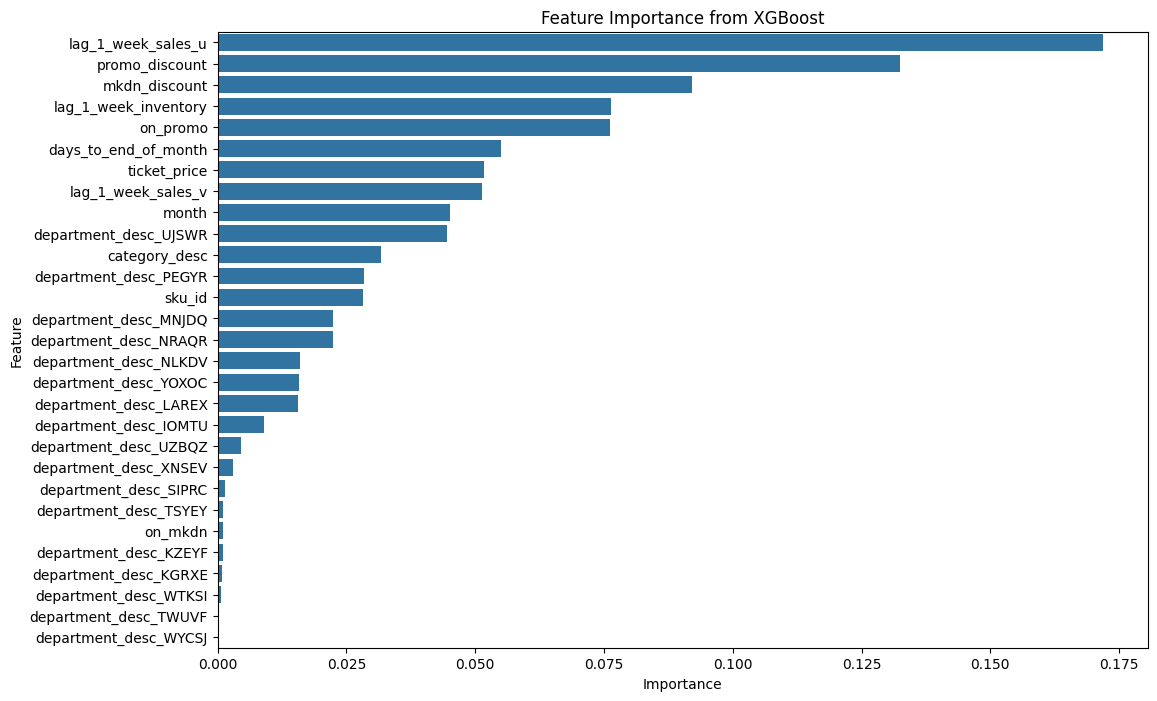

In [53]:
# Get feature importance
importances = best_model.feature_importances_

# Create a DataFrame to display the importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,  # Assuming X_train has the feature names
    'importance': importances
})

# Sort the features by importance in descending order
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

# Display the top 10 most important features
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance from XGBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

#Final Predicitons

In [54]:
# Creating results set

# De-encoding the product identifiers for potential use
encoded_sku_ids = X_test.iloc[:, 0]
sku_ids_test = label_encoder1.inverse_transform(encoded_sku_ids)

results = pd.DataFrame({
    'sku_id': sku_ids_test,
    'actual_sales': y_test,
    'predicted_sales': y_predxgb
})

In [55]:
# Aggregate results by product

sku_results = results.groupby('sku_id').agg(
    total_actual_sales=('actual_sales', 'sum'),
    total_predicted_sales=('predicted_sales', 'sum')
)

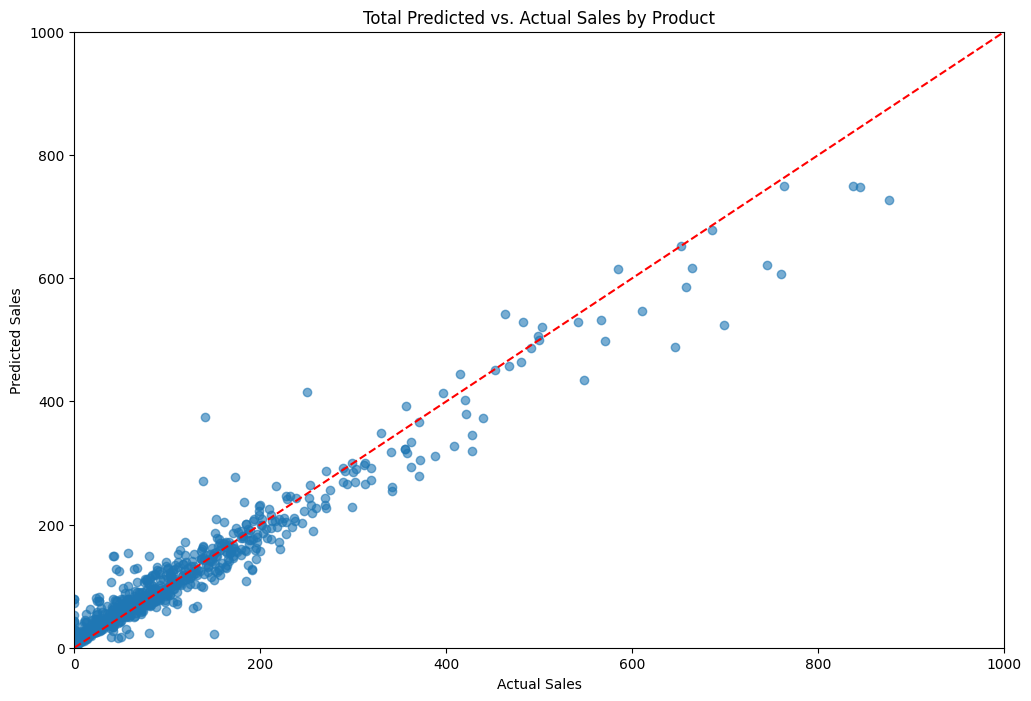

In [56]:
# Plot total actual vs predicted sales by product for the test data

plt.figure(figsize=(12, 8))
plt.scatter(sku_results['total_actual_sales'], sku_results['total_predicted_sales'], alpha=0.6)
plt.plot([sku_results['total_actual_sales'].min(), sku_results['total_actual_sales'].max()],
         [sku_results['total_actual_sales'].min(), sku_results['total_actual_sales'].max()],
         '--', color='red')
plt.title('Total Predicted vs. Actual Sales by Product')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.xlim(0, 1000) # Focusing on the vast majority of the data
plt.ylim(0, 1000)
plt.show()

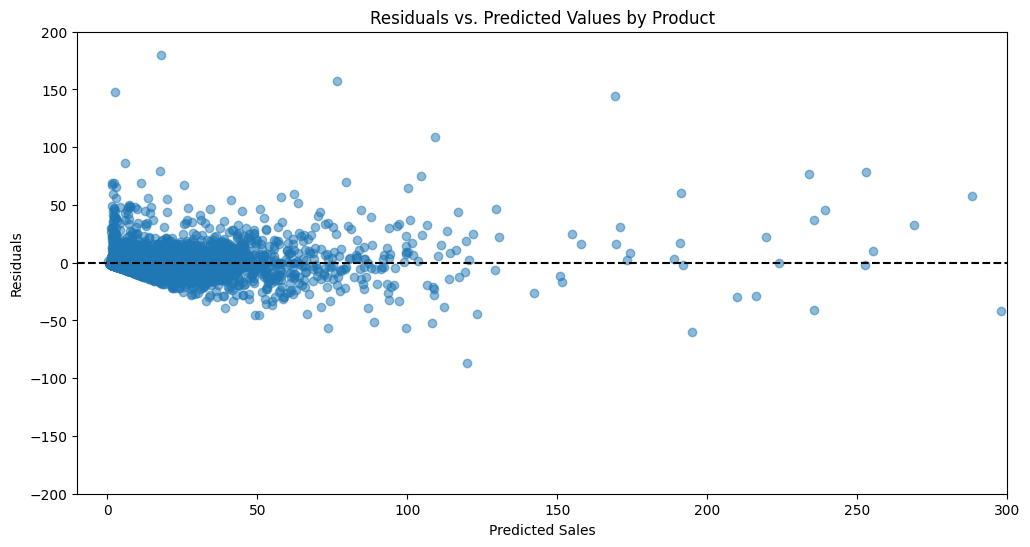

In [57]:
# Residuals vs. Predicted Values

# Calculate residuals
residuals = results['actual_sales'] - results['predicted_sales']

plt.figure(figsize=(12, 6))
plt.scatter(results['predicted_sales'], residuals, alpha=0.5)
plt.axhline(y=0, color='black', linestyle='--')  # Zero line
plt.title('Residuals vs. Predicted Values by Product')
plt.xlabel('Predicted Sales')
plt.ylabel('Residuals')
plt.xlim(-10, 300) # Focusing on the vast majority of the data
plt.ylim(-200, 200)
plt.show()


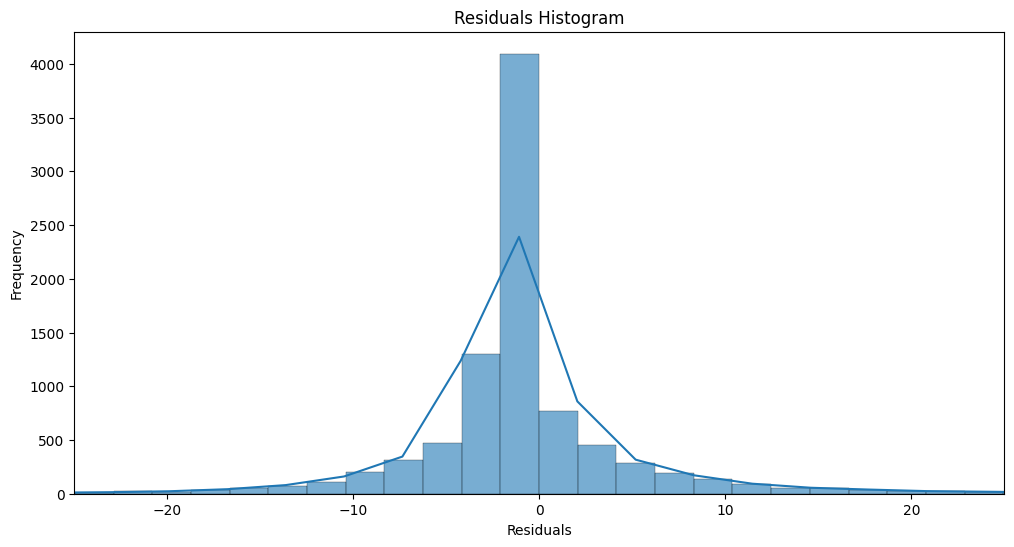

In [58]:
# Residuals histogram

plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, bins=300, alpha=0.6)
plt.title('Residuals Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.xlim(-25, 25) # Focusing on the majority of the data
plt.show()